In [2]:
%load_ext autoreload
%autoreload 2

In [1]:
%%file mrlogit.py
import math
from mrjob.job import MRJob


def parse_line(line):
    values = [float(v) for v in line.split(',')]
    return values[0], [1.] + values[1:]
    
def y(x, w):
    d = sum(a*b for a, b in zip(x, w))
    return 1. / (1. + math.exp(-d))  # TODO: implement logit function

class MRLogit(MRJob):

    def configure_options(self):
        super(MRLogit, self).configure_options()
        self.add_passthrough_option('--weights', type='str')
        
    def mapper(self, _, line):
        w = [float(e) for e in self.options.weights.split(',')]
        t, x = parse_line(line)
        error = y(x, w) - t
        for i in range(len(x)):
            yield i, error * x[i]  # TODO: yield intermediate gradient values

    def reducer(self, key, values):
        yield key, sum(values)  # TODO: calculate final gradient values 

Overwriting mrlogit.py


In [4]:
import math
import random
from mrlogit import MRLogit
from mrlogit import parse_line
from mrlogit import y as predict

random.seed(123)
w = [random.random() for i in range(3)]
a = 1e-1

def loss():
    with open('../data/logit.txt') as src:
        res, count = 0., 0.
        for line in src:
            t, x = parse_line(line)
            y = predict(x, w)
            res += - (t * math.log(y + 1e-32) + (1. - t) * math.log(1. - y + 1e-32))
            count += 1
        return res / count

loss_data = []
for i in range(100):
    _w = ','.join(map(str, w))
    job = MRLogit(args=['../data/logit.txt', '--weights', _w])
    with job.make_runner() as runner:
        runner.run()
        for line in runner.stream_output():
            k, v = job.parse_output_line(line)
            w[k] -= a * v / 100

    loss_data.append(loss())
    if i % 10 == 0:
        print(loss())

0.7480323218531248
0.569922821792644
0.47890373646543727
0.42001866627213547
0.37896610093913574
0.34887726765681976
0.3259351580692985
0.30787988803811284
0.2933022994800416
0.2812833773446794


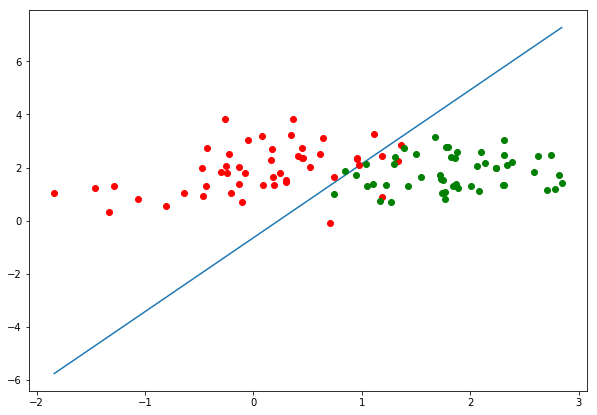

In [5]:
%matplotlib inline
from matplotlib import pyplot as plt

with open('../data/logit.txt') as src:
    data = [[float(v) for v in line.split(',')] for line in src]

data_0_x1 = [v[1] for v in data if v[0] == 0]
data_0_x2 = [v[2] for v in data if v[0] == 0]

data_1_x1 = [v[1] for v in data if v[0] == 1]
data_1_x2 = [v[2] for v in data if v[0] == 1]

x1 = sorted([v[1] for v in data])
x2 = [- w[0] / w[2] - x * w[1] / w[2] for x in x1]

# plot objects and hyperplane
plt.figure(figsize=(10,7))
plt.plot(x1, x2, '-',
         data_0_x1, data_0_x2, 'or',
         data_1_x1, data_1_x2, 'og')